# NBA Score Predictions Pipeline

### Necessary Imports

In [49]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm 
import seaborn as sns

import random as rnd
import statistics
import math
import numpy as np

### Lists/Dicts for Conferences, Teams, Abbrs, Names

In [5]:
conferences = {'GSW':'WEST', 'POR':'WEST', 'SAC':'WEST', 'UTA':'WEST', 'MIA':'EAST', 'DEN':'WEST', 'MIN':'WEST',
               'PHI':'EAST', 'NOP':'EAST', 'ORL':'EAST', 'MIL':'EAST', 'CHI':'EAST','DET':'EAST', 'TOR':'EAST',
               'PHX':'WEST', 'LAL':'WEST', 'ATL':'EAST', 'WAS':'EAST', 'MEM':'WEST', 'CLE':'EAST', 'LAC':'WEST',
               'BOS':'EAST', 'NYK':'EAST', 'IND':'EAST', 'CHA':'EAST', 'SAS':'WEST', 'HOU':'WEST', 'DAL':'WEST',
               'OKC':'WEST', 'BKN':'EAST'}

team_names =     ['Utah Jazz', 'Sacramento Kings', 'Washington Wizards',
                  'Boston Celtics', 'Milwaukee Bucks', 'Oklahoma City Thunder',
                  'Chicago Bulls', 'Phoenix Suns', 'Philadelphia 76ers',
                  'New Orleans Pelicans', 'Charlotte Hornets', 'Los Angeles Lakers',
                  'Indiana Pacers', 'Toronto Raptors', 'Cleveland Cavaliers',
                  'Denver Nuggets', 'Minnesota Timberwolves', 'Brooklyn Nets',
                  'San Antonio Spurs', 'Dallas Mavericks', 'Houston Rockets',
                  'Detroit Pistons', 'Portland Trail Blazers', 'Atlanta Hawks',
                  'Golden State Warriors', 'Miami Heat', 'Los Angeles Clippers',
                  'New York Knicks', 'Memphis Grizzlies', 'Orlando Magic', 'League Average']

team_names_nocity = ['Jazz', 'Kings', 'Wizards', 'Celtics', 'Bucks', 'Thunder',
                  'Bulls', 'Suns', '76ers', 'Pelicans', 'Hornets', 'Lakers',
                  'Pacers', 'Raptors', 'Cavaliers', 'Nuggets', 'Timberwolves', 'Nets',
                  'Spurs', 'Mavericks', 'Rockets', 'Pistons', 'Trail Blazers', 'Hawks',
                  'Warriors', 'Heat', 'Clippers','Knicks', 'Grizzlies', 'Magic', 'League Average']

team_abbrs =     ['UTA', 'SAC', 'WAS', 'BOS', 'MIL', 'OKC', 'CHI', 'PHX', 'PHI',
                  'NOP', 'CHA', 'LAL', 'IND', 'TOR', 'CLE', 'DEN', 'MIN', 'BKN',
                  'SAS', 'DAL', 'HOU', 'DET', 'POR', 'ATL', 'GSW', 'MIA', 'LAC',
                  'NYK', 'MEM', 'ORL', 'NBA']

team_name_abbr_dict = {}
team_abbr_name_dict = {}
team_names_nocity_dict = {}
team_id_dict={}

for i in range(len(team_names)):
    team_name_abbr_dict[team_names[i]]=team_abbrs[i]
    
for i in range(len(team_names_nocity)):
    team_names_nocity_dict[team_names_nocity[i]]=team_abbrs[i]

for i in range(len(team_abbrs)):
    team_abbr_name_dict[team_abbrs[i]]=team_names[i]

### Webscrape 2022-2023 NBA Boxscore Data

In [6]:
url = 'https://stats.nba.com/stats/leaguegamelog'
headers= {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
          'Referer': 'https://www.nba.com/'}
payload = {
    'Counter': '1000',
    'DateFrom': '',
    'DateTo': '',
    'Direction': 'DESC',
    'LeagueID': '00',
    'PlayerOrTeam': 'T',
    'Season': '2022-23',
    'SeasonType': 'Regular Season',
    'Sorter': 'DATE'}

jsonData = requests.get(url, headers=headers, params=payload).json()


rows = jsonData['resultSets'][0]['rowSet']
columns = jsonData['resultSets'][0]['headers']

df = pd.DataFrame(rows, columns=columns)
df.drop(['VIDEO_AVAILABLE'], axis=1, inplace=True)


df['FG2M'] = df.FGM - df.FG3M
df['FG2A'] = df.FGA - df.FG3A

df['FG2_PTS'] = df.FG2M * 2
df['FG3_PTS'] = df.FG3M * 3

df['OPP_TEAM_ABBR'] = df['MATCHUP'].str.strip().str[-3:]
df['OPP_PTS'] = df['PTS'] - df['PLUS_MINUS']

df['MONTH'] = pd.DatetimeIndex(df['GAME_DATE']).month
df['YEAR'] = pd.DatetimeIndex(df['GAME_DATE']).year

def home_or_away(string):
    if string[4]=='@': return 'AWAY'
    elif string[4]=='v': return 'HOME'
    
df['HOME_AWAY'] = df['MATCHUP'].map(home_or_away)

df['CONFERENCE'] = df['TEAM_ABBREVIATION'].apply(lambda x: conferences.get(x))
df['OPP_CONFERENCE'] = df['OPP_TEAM_ABBR'].apply(lambda x: conferences.get(x))


df['DATE_MATCHUP'] = df['GAME_DATE'].str[5:] + ' ' + df['MATCHUP'].str[4:]
#df['DATE_MATCHUP'] = df['GAME_DATE'] + ' ' + df['MATCHUP'].str[4:]

df.TEAM_NAME = df.TEAM_ABBREVIATION.apply(lambda x: team_abbr_name_dict.get(x))

df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FG2M,FG2A,FG2_PTS,FG3_PTS,OPP_TEAM_ABBR,OPP_PTS,MONTH,YEAR,HOME_AWAY,CONFERENCE,OPP_CONFERENCE,DATE_MATCHUP
0,22022,1610612755,PHI,Philadelphia 76ers,0022200770,2023-02-01,PHI vs. ORL,None,180,34,78,0.436,14,35,0.400,21,22,0.955,7,36,43,27,6,4,18,24,103,11,20,43,40,42,ORL,92,2,2023,HOME,EAST,EAST,02-01 vs. ORL
1,22022,1610612753,ORL,Orlando Magic,0022200770,2023-02-01,ORL @ PHI,None,180,32,86,0.372,6,38,0.158,22,29,0.759,12,34,46,12,10,4,14,18,92,-11,26,48,52,18,PHI,103,2,2023,AWAY,EAST,EAST,02-01 @ PHI
2,22022,1610612762,UTA,Utah Jazz,0022200776,2023-02-01,UTA vs. TOR,None,0,3,7,0.429,0,2,0.000,2,2,1.000,1,4,5,1,0,2,1,0,8,6,3,5,6,0,TOR,2,2,2023,HOME,WEST,EAST,02-01 vs. TOR
3,22022,1610612759,SAS,San Antonio Spurs,0022200775,2023-02-01,SAS vs. SAC,None,120,25,46,0.543,3,12,0.250,1,1,1.000,2,16,18,17,1,1,7,6,54,-9,22,34,44,9,SAC,63,2,2023,HOME,WEST,WEST,02-01 vs. SAC
4,22022,1610612758,SAC,Sacramento Kings,0022200775,2023-02-01,SAC @ SAS,None,120,27,48,0.563,2,13,0.154,7,7,1.000,2,18,20,13,5,2,4,5,63,9,25,35,50,6,SAS,54,2,2023,AWAY,WEST,WEST,02-01 @ SAS


### Function that webscrapes and displays todays NBA matchups

In [7]:
def today_matchups():
    url = "https://www.espn.com/nba/scoreboard"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    date = soup.find('h3', class_="Card__Header__Title Card__Header__Title--no-theme").text

    games = soup.find_all("div", class_='Scoreboard__RowContainer flex flex-column flex-auto')
    games_data = []

    df = pd.DataFrame()

    for game in games:
        game_data = {}
        away_tm = game.find_all("div", class_="ScoreCell__TeamName ScoreCell__TeamName--shortDisplayName truncate db")[0]
        home_tm = game.find_all("div", class_="ScoreCell__TeamName ScoreCell__TeamName--shortDisplayName truncate db")[1]
        game_data['Date'] = date
        game_data["away_tm"] = away_tm.text
        #game_data["away_tm_abbr"] = team_names_nocity_dict[away_tm.text]
        
        game_data["home_tm"] = home_tm.text
        #game_data["home_tm_abbr"] = team_names_nocity_dict[home_tm.text]
        
        
        games_data.append(game_data)

    df = pd.DataFrame(games_data)
    
    print(soup.title.text)
    print(date)
    display(df)

today_matchups()

NBA Basketball Scores - NBA Scoreboard - ESPN
Wednesday, February 1, 2023


,Date,away_tm,home_tm
0,"Wednesday, February 1, 2023",Thunder,Rockets
1,"Wednesday, February 1, 2023",Warriors,Timberwolves
2,"Wednesday, February 1, 2023",Raptors,Jazz
3,"Wednesday, February 1, 2023",Hawks,Suns
4,"Wednesday, February 1, 2023",Magic,76ers
5,"Wednesday, February 1, 2023",Trail Blazers,Grizzlies
6,"Wednesday, February 1, 2023",Nets,Celtics
7,"Wednesday, February 1, 2023",Kings,Spurs
8,"Wednesday, February 1, 2023",Wizards,Pistons


### Function that simulates a matchup a specified number of times

In [10]:
def multi_game_simulations(n, team1abbr, team2abbr):
    
    def gauss_game_sim(team1abbr, team2abbr):
        team1Score = int(round(rnd.gauss(df[df.TEAM_ABBREVIATION==team1abbr].PTS.mean(),df[df.TEAM_ABBREVIATION==team1abbr].PTS.std())\
                     +rnd.gauss(df[df.TEAM_ABBREVIATION==team2abbr].OPP_PTS.mean(),df[df.TEAM_ABBREVIATION==team2abbr].OPP_PTS.std()))/2)

        team2Score = int(round(rnd.gauss(df[df.TEAM_ABBREVIATION==team2abbr].PTS.mean(),df[df.TEAM_ABBREVIATION==team2abbr].PTS.std())\
                     +rnd.gauss(df[df.TEAM_ABBREVIATION==team1abbr].OPP_PTS.mean(),df[df.TEAM_ABBREVIATION==team1abbr].OPP_PTS.std()))/2)

        if team1Score > team2Score:
            return 1, team1Score, team2Score
        elif team1Score < team2Score:
            return -1, team1Score, team2Score
        else: return 0, team1Score, team2Score
    
    gameResults = []
    team1Wins = 0
    team2Wins = 0
    Ties = 0
    team1scores=[]
    team2scores=[]
    for i in range(n):
        gm, tm1sc, tm2sc = gauss_game_sim(team1abbr, team2abbr)
        team1scores.append(tm1sc)
        team2scores.append(tm2sc)
        gameResults.append(gm)
        if gm == 1:
            team1Wins += 1
        elif gm == -1:
            team2Wins += 1
        else: Ties += 1
            
    team1WinPer = team1Wins/(n)
    team2WinPer = team2Wins/(n)
    TiePer = Ties/(n)
    
    team1MeanSc = statistics.mean(team1scores)
    team2MeanSc = statistics.mean(team2scores)

    return team1WinPer, team2WinPer, team1MeanSc, team2MeanSc, team1scores, team2scores

### Todays matchups with with n-simulations win% and mean score for each matchup 

NBA Basketball Scores - NBA Scoreboard - ESPN
Wednesday, February 1, 2023
Through 100 simulations


,Date,away_tm,away_sim_W%,away_mean_sc,home_tm,home_sim_W%,home_mean_sc
0,"Wednesday, February 1, 2023",Hawks,0.390000,112.970000,Suns,0.550000,115.130000
1,"Wednesday, February 1, 2023",Magic,0.400000,110.860000,76ers,0.560000,112.550000
2,"Wednesday, February 1, 2023",Trail Blazers,0.340000,112.410000,Grizzlies,0.620000,114.910000
3,"Wednesday, February 1, 2023",Nets,0.410000,112.230000,Celtics,0.570000,114.800000
4,"Wednesday, February 1, 2023",Thunder,0.730000,117.270000,Rockets,0.250000,111.480000
5,"Wednesday, February 1, 2023",Warriors,0.470000,116.050000,Timberwolves,0.500000,116.130000
6,"Wednesday, February 1, 2023",Kings,0.670000,118.130000,Spurs,0.310000,111.810000
7,"Wednesday, February 1, 2023",Raptors,0.530000,112.500000,Jazz,0.460000,111.140000
8,"Wednesday, February 1, 2023",Wizards,0.640000,117.070000,Pistons,0.340000,112.420000


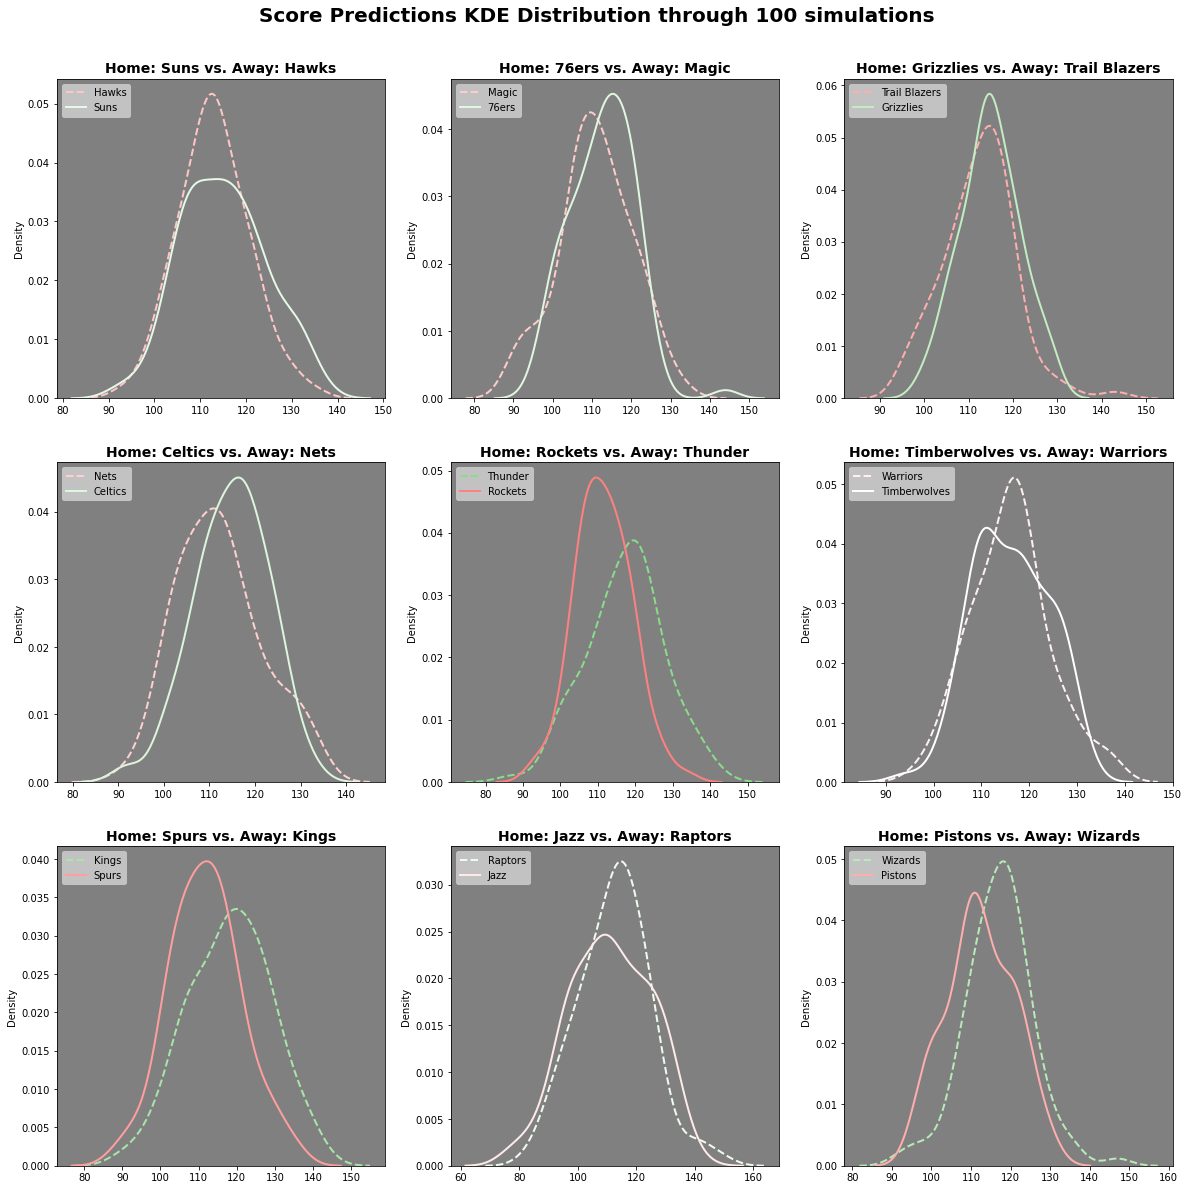

In [107]:
def today_multi_preds(n):
    url = "https://www.espn.com/nba/scoreboard"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    date = soup.find('h3', class_="Card__Header__Title Card__Header__Title--no-theme").text

    games = soup.find_all("div", class_='Scoreboard__RowContainer flex flex-column flex-auto')
    games_data = []

    df = pd.DataFrame()
    
    i,j=0,0
    PLOTS_PER_ROW = 3
    
    cdict = {'red': ((0.0, 0.0, 0.0),
                (0.5, 1.0, 1.0),
                (1.0, 1.0, 0.7)),

        'green': ((0.0, 0.7, 0.7),
                  (0.5, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),

         'blue': ((0.0, 0.0, 0.0),
                  (0.5, 1.0, 1.0),
                  (1.0, 0.0, 0.0))
         }
    GnRd = colors.LinearSegmentedColormap('GnRd', cdict).reversed()
    
    fig, axs = plt.subplots(nrows=math.ceil(len(games)/PLOTS_PER_ROW),ncols=PLOTS_PER_ROW, figsize=(20, 20))
    
    fig.suptitle(f'Score Predictions KDE Distribution through {n} simulations', y=0.93, fontsize=20, fontweight='bold')
    
    for game in games:
        game_data = {}
        
        away_tm = game.find_all("div", class_="ScoreCell__TeamName ScoreCell__TeamName--shortDisplayName truncate db")[0]
        home_tm = game.find_all("div", class_="ScoreCell__TeamName ScoreCell__TeamName--shortDisplayName truncate db")[1]
        
        away_sim_Wper, home_sim_Wper, away_mn_sc, home_mn_sc, away_scores, home_scores = multi_game_simulations(n, team_names_nocity_dict[away_tm.text], team_names_nocity_dict[home_tm.text])
        
        game_data['Date'] = date
        
        game_data["away_tm"] = away_tm.text
        #game_data["away_tm_abbr"] = team_names_nocity_dict[away_tm.text]
        game_data[f"away_sim_W%"] = away_sim_Wper
        game_data[f"away_mean_sc"] = away_mn_sc
        
        game_data["home_tm"] = home_tm.text
        #game_data["home_tm_abbr"] = team_names_nocity_dict[home_tm.text]
        game_data[f"home_sim_W%"] = home_sim_Wper
        game_data[f"home_mean_sc"] = home_mn_sc
        
        games_data.append(game_data)
        axs[i][j].set_facecolor('grey')
        sns.kdeplot(np.array(away_scores), ax=axs[i][j], color=GnRd(away_sim_Wper), linewidth=2, linestyle='--', label=away_tm.text)
        sns.kdeplot(np.array(home_scores), ax=axs[i][j], color=GnRd(home_sim_Wper), linewidth=2, label=home_tm.text)
        
        axs[i][j].legend(loc='upper left', facecolor='lightgrey')
        
        axs[i][j].set_title(f'Home: {home_tm.text} vs. Away: {away_tm.text}', fontsize=14, fontweight='bold')
        
        j+=1
        if j%PLOTS_PER_ROW==0:
            i+=1
            j=0

    df = pd.DataFrame(games_data)
    
    print(soup.title.text)
    print(date)
    print(f'Through {n} simulations')
    
    df = df.style.background_gradient(axis=None, subset=['away_sim_W%','home_sim_W%'], cmap=GnRd, vmin=0.25, vmax=0.75)
    display(df)

    plt.show()

today_multi_preds(100)